In [1]:
import sys
sys.version

'3.9.1 (default, Dec 11 2020, 06:28:49) \n[Clang 10.0.0 ]'

In [23]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/'

Use Kepler Berger et al 2020 data crossmatched with Gaia courtesy of Bedell's gaia-kepler.fun to read in resulting transit multiplicity, as well as stellar radius KDE so that that parameter can be drawn from a somewhat informed distribution. 

In [3]:
berger_kepler = pd.read_csv('berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/envs/sculpting/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# transit multiplicity from Kepler/Gaia Berger et al 2020/Bedell to compare our models against
pnum = pd.read_csv(path+'pnum.csv')
k = pnum.pl_pnum.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 89, 30, 21, 16, 5]) # compact multi rate with 7%
print(k)


0    19808
1       89
2       30
3       21
4       16
5        5
dtype: int64


/Users/chris/anaconda2/envs/sculpting/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [176]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


0.16134894568048894
0.13801577758850292
19969 [2.25466466 3.55021021 2.63914915 ... 1.82838839 1.65286286 1.97883884]


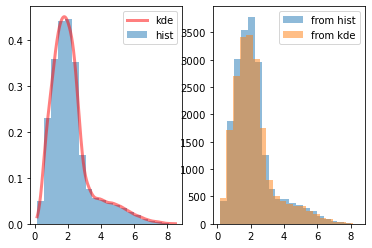

[2.25466466 3.55021021 2.63914915 ... 1.82838839 1.65286286 1.97883884]


In [5]:
# courtesy of https://stackoverflow.com/questions/17821458/random-number-from-histogram

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

#kdepdf = kde(x, x_d, bandwidth=0.1) # generate KDE model
#random_from_kde = generate_rand_from_pdf(kdepdf, x_d) # generate random data from KDE distribution

nbins = 20
def run_kde(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
    print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(random_from_kde, nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde, random_from_cdf
    
stars_age1_kde, stars_radius_cdf = run_kde(berger_kepler.iso_age, len(berger_kepler))
print(stars_age1_kde)

Define key functions for simulations and pymultinest

In [55]:
def transit_duration(P, r_star, r_planet, b, a, inc): # Winn 2011 Eqn 14
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    print("arg1: ", arg1)
    arg2 = (r_star / np.array(a)) * (arg1 / np.sin(np.pi/2 - np.array(inc))) # was sin(i) but need to adjust for different index
    print("arg2: ", arg2)
    return (np.array(P) / np.pi) * np.arcsin(arg2)

def transit_duration_paw(P, r_star, r_planet, b, a, inc): 
    # https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    arg2 = (r_star / a) * arg1 # the only difference is I don't divide by sin(i)
    return (P / np.pi) * np.arcsin(arg2)
    
def transit_duration_normalized_fab(P, r_star, r_planet, b): # Fabrycky 2012 unnamed eqn at the end of pg 8
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    return 2 * arg1 * r_star / (P**(-1./3))
    
def calculate_xi(tdur1, tdur2, P1, P2): # Fabrycky 2012 Eqn 1
    arg1 = tdur1/(P1**(1./3))
    arg2 = tdur2/(P2**(1./3))
    return arg1 / arg2

def day_to_year(per):
    return per/365.24 

def solar_radius_to_au(radius):
    return 0.00465047*radius

def au_to_solar_radius(au):
    return 215.032*au

def earth_radius_to_au(radius):
    return 4.26352e-5*radius

def sim_transits_old(r_star, num_planets, mu, sigma, r_planet, age_star):
    """
    In a loop of stellar radii: draw number of planets and their periods, draw midplane for the system, 
    draw inclination from the midplane for each planet, convert period to a, calculate impact parameter b, 
    calculate transit duration, calculate normalized transit duration xi (aka mutual inclination proxy),
    classify each planet as transiting or not
    
    Parameters
    ----------
    r_star: radius of the star
    num_planets: number of planets sampled based on stellar age check
    mu: planetary disk midplane in radians
    sigma: sigma used in drawing planet inclinations from around the midplane
    r_planet: radius of the planet
    age_star: age of the star
    
    Returns
    -------
    None: populates a bunch of different lists set up before the loop in which function is called,
    including those for inclination, period, semi-major axis, impact parameter, and transit duration
    
    """
    
    # draw planet periods from loguniform distribution according to num_planets
    planet_per_case2 = list(loguniform.rvs(2, 300, size=num_planets)) 
    planets_per_case2.append(planet_per_case2) 

    # inclinations for impact parameter formula
    inclination = list(np.random.normal(mu, sigma, num_planets)) # need this for later
    inclinations.append(inclination) 
    inclinations_degrees.append([inc*180/np.pi for inc in inclination]) 

    # semi-major axes based on Kepler's Third Law
    planet_a_case2 = [day_to_year(ppc2)**(2./3) for ppc2 in planet_per_case2]
    planets_a_case2.append(planet_a_case2) 
    
    # calculate impact parameters
    b = (planet_a_case2 * np.sin(inclination))/r_star
    impact_parameters.append(list(b))

    # calculate transit durations using Winn 2011 formula
    tdur = transit_duration([day_to_year(ppc2) for ppc2 in planet_per_case2], solar_radius_to_au(r_star), 
                            earth_radius_to_au(r_planet), b, planet_a_case2, inclination)
    
    """
    ### calculate xi for the system
    # periods and tdurs already match, so divide them to get normalized tdurs
    tdur_normalized = tdur/(day_to_year(planet_per_case2)**(1./3))

    # make sure I keep info on which tdur_normalized corresponds with which planet
    temp = pd.DataFrame({'period': planet_per_case2, 'tdur_normalized': tdur_normalized})
    temp = temp.dropna()

    # guarantee that xi will always have normalized transit durations of inner planet in numerator 
    temp = temp.sort_values(by='period') 
    #print(temp)
    tdur_normalized_combos = list(itertools.combinations(temp.tdur_normalized,2))
    #print("combos: ", tdur_normalized_combos)

    for combo in tdur_normalized_combos:
        xi.append(combo[0]/combo[1])
        if age_star <= 1.:
            xi_young.append(combo[0]/combo[1])
        elif age_star > 1:
            xi_old.append(combo[0]/combo[1])
    """

    # note individual planets' transit status
    transit_status.append([1 if np.abs(param) <= 1. else 0 for param in b])

    # transit check based on impact parameters
    transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
    
def sim_transits(r_star, num_planets, mu, sigma, r_planet, age_star, planets_per_case2,
    planets_a_case2, inclinations, inclinations_degrees, impact_parameters, transit_status,
    transit_multiplicities, tdurs, jmags, cdpps, sns):
    """
    In a loop of stellar radii: draw number of planets and their periods, draw midplane for the system, 
    draw inclination from the midplane for each planet, convert period to a, calculate impact parameter b, 
    calculate transit duration, calculate normalized transit duration xi (aka mutual inclination proxy),
    classify each planet as transiting or not
    
    Parameters
    ----------
    r_star: radius of the star
    num_planets: number of planets sampled based on stellar age check
    mu: planetary disk midplane in radians
    sigma: sigma used in drawing planet inclinations from around the midplane
    r_planet: radius of the planet
    age_star: age of the star

    possible **kwargs are empty arrays:
    planets_per_case2
    inclinations
    inclinations_degrees
    planets_a_case2
    impact_parameters
    transit_status
    transit_multiplicities
    
    Returns
    -------
    None: populates a bunch of different lists set up before the loop in which function is called,
    including those for inclination, period, semi-major axis, impact parameter, transit duration,
    transit status, transit multiplicity, and S/N
    
    """

    # draw planet periods from loguniform distribution according to num_planets
    planet_per_case2 = list(loguniform.rvs(2, 300, size=num_planets)) 
    planets_per_case2.append(planet_per_case2) 

    # inclinations for impact parameter formula
    inclination = list(np.random.normal(mu, sigma, num_planets)) # need this for later
    inclinations.append(inclination) 
    inclinations_degrees.append([inc*180/np.pi for inc in inclination]) 

    # semi-major axes based on Kepler's Third Law
    planet_a_case2 = [day_to_year(ppc2)**(2./3) for ppc2 in planet_per_case2]
    planets_a_case2.append(planet_a_case2) 
    
    # calculate impact parameters
    b = (planet_a_case2 * np.sin(inclination))/r_star
    impact_parameters.append(list(b))
    
    # note individual planets' transit status
    transit_status.append([1 if np.abs(param) <= 1. else 0 for param in b])

    # transit check based on impact parameters
    transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
    
    # calculate transit durations using Winn 2011 formula
    tdur = transit_duration([day_to_year(ppc2) for ppc2 in planet_per_case2], solar_radius_to_au(r_star), 
                            solar_radius_to_au(r_planet), b, planet_a_case2, inclination)
    tdurs.append(tdur)
    
    # draw jmags based on age-jmag relation, given age
    jmag = build_and_sample_from_2dpdf(berger_kepler.iso_age, berger_kepler.jmag, age_star)
    jmags.append(jmag)
    
    # draw 6-hr transit duration cdpp based on jmag-cdpp relation, given jmag that we just sampled
    cdpp = build_and_sample_from_2dpdf(berger_kepler.jmag, berger_kepler.rrmscdpp06p0, jmag)
    cdpps.append(cdpp)
    
    # calculate S/N using Christiansen et al 2012 Eqn 4
    sn = calculate_sn([day_to_year(ppc2) for ppc2 in planet_per_case2], r_planet, r_star, cdpp, tdur)
    sns.append(sn)
    
def calculate_sn(P, rp, rs, cdpp, tdur): # calculate S/N per planet using Eqn 4 in Christiansen et al 2012
    tobs = 300 # days; time spanned observing the target; set to max period from logN sample space
    f0 = 0.92 # fraction of time spent actually observing and not doing spacecraft things
    tcdpp = 0.25 # days; using CDPP for 6 hour transit durations; could change to be more like Earth transiting Sun?
    
    factor1 = np.sqrt(tobs*f0/np.array(P))
    delta = (rp/rs)**2
    cdpp_eff = cdpp * np.sqrt(tcdpp/tdur)
    factor2 = delta/cdpp_eff
    sn = factor1 * factor2
    return sn

In [48]:
calculate_sn(3, 0.1, 1, 0.001, 0.1) # realistic
# 3 days, 0.1 rp/rs, CDPP of 1000, 2.4 hr transit

60.66300355241241

In [10]:
def prior(cube, ndim, nparams):
    """
    Scales unit hypercube sample to appropriate bounds in each dimension of hyperparam space
    """
    cube[0] = cube[0]-1 # from -1 to 0
    cube[1] = cube[1]*10 # from 0 to 10
    print(cube)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def model(cube):
    """
    Take prior and make 20000 systems out of it
    Params: cube is the 2D prior
    Returns: tuple of transit multiplicities
    """
    # retrieve prior
    #print(cube)
    m, b = cube[0], cube[1]
    
    star_index = []
    midplanes = []
    midplanes_degrees = []
    inclinations = []
    inclinations_degrees = []
    planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
    planets_a_case2 = []
    star_radius = []
    impact_parameters = []
    transit_status = []
    transit_multiplicities = []
    tdurs = []
    jmags = []
    cdpps = []
    sns = []
    xi = []
    xi_old = []
    xi_young = []
    
    # draw 20000 systems
    for i in range(len(stars_age1_kde)):
        # star
        star_index.append(i)
        #r_star = stars_radius_kde[i] # nope
        r_star = solar_radius_to_au(1.) # set to 1 solar radius
        age_star = stars_age1_kde[i]
        mu = list(np.random.uniform(-np.pi/2,np.pi/2,1)) # create midplane for star 
        midplanes.append(mu)
        midplanes_degrees.append([mu_elt*180/np.pi for mu_elt in mu])
        
        # planet
        r_planet = earth_radius_to_au(2.) # use two Earth radii; will make negligible difference
        prob = m * age_star + b # calculate probability given age from sampled distribution
        if prob < 0: # don't allow negative probabilities
            prob = 0
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 
            sigma = np.pi/90 # 2 degrees, per Fig 6 in Fabrycky 2012
            
            # simulate transit-related characteristics for 5 or 6 planets
            sim_transits(r_star, num_planets, mu, sigma, r_planet, age_star,
                planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                inclinations = inclinations, inclinations_degrees = inclinations_degrees,
                impact_parameters = impact_parameters, transit_status = transit_status, 
                transit_multiplicities = transit_multiplicities, tdurs = tdurs,
                jmags = jmags, cdpps = cdpps, sns = sns)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 
            sigma = np.pi/22.5 # 8 degree disk plane inclination scatter
            
            # simulate transit-related characteristics for 1 or 2 planets
            sim_transits(r_star, num_planets, mu, sigma, r_planet, age_star,
                planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                inclinations = inclinations, inclinations_degrees = inclinations_degrees,
                impact_parameters = impact_parameters, transit_status = transit_status, 
                transit_multiplicities = transit_multiplicities, tdurs = tdurs, 
                jmags = jmags, cdpps = cdpps, sns = sns)

    midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

    transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case2, 
                     'semi_major_axes': planets_a_case2, 'midplane': midplanes,
                     'midplane_degrees': midplanes_degrees,
                     'planet_inclinations': inclinations, 'planet_inclinations_degrees': inclinations_degrees,
                     'impact_parameters': impact_parameters, 'transit_status': transit_status, 
                     'transit_multiplicity': transit_multiplicities, 'star_index': star_index,
                    'y_intercept': b, 'slope': m, 'transit_duration': tdurs, 'jmags': jmags, 
                     '6hr_cdpp': cdpp, 'signal_noise': sns}

    transits = pd.DataFrame(transits_dict)
    transits.to_csv('sims/transits.csv')
    
    # calculate and return transit multiplicity for this set of systems, normalized against number of transiters from crossmatched data
    # formerly normalized by 161 bc that was total of k; using 316 now that I'm including candidates too
    lam = transits.loc[transits.transit_multiplicity > 0].transit_multiplicity.value_counts() * (np.sum(k)/len(transits.loc[transits.transit_multiplicity > 0]))
    
    return lam

def loglike_old(cube, ndim, nparams):
    """
    Poisson log likelihood from synthetic-posteriors.ipynb

    Returns: Poisson log-likelihood
    """
    lam = model(cube) # feed prior-normalized hypercube into model to generate transit multiplicities
    print("MODEL: ", ymodel)
    print("DATA: ", k) # from Berger et al 2020 crossmatched with Gaia via Bedell's kepler-gaia.fun
    
    term1 = np.sum(k * np.log(lam))
    term2 = -np.sum(lam)
    term3 = -np.sum([lgamma(kth + 1) for kth in k])
    poisson_loglikelihood = term1 + term2 + term3
    return poisson_loglikelihood

def loglike(cube, ndim, nparams):
    """
    Poisson log likelihood from synthetic-posteriors.ipynb

    Returns: Poisson log-likelihood
    """

    # retrieve prior cube and feed prior-normalized hypercube into model to generate transit multiplicities
    lam = model(cube)
    #print("MODEL: ", lam)
    #print("DATA: ", k) # from Berger et al 2020 crossmatched with Gaia via Bedell's kepler-gaia.fun
    
    term1 = np.sum(k * np.log(lam))
    term2 = -np.sum(lam)
    term3 = -np.sum([lgamma(kth + 1) for kth in k])
    poisson_loglikelihood = term1 + term2 + term3
    #print("POISSON: ", poisson_loglikelihood)
    return poisson_loglikelihood, lam

def loglike_model_done(lam, ndim, nparams):
    """
    Poisson log likelihood from synthetic-posteriors.ipynb

    Returns: Poisson log-likelihood
    """
    term1 = np.sum(k * np.log(lam))
    print("TERM 1: ", term1)
    term2 = -np.sum(lam)
    term3 = -np.sum([lgamma(kth + 1) for kth in k]) # the more nonzero bins you have, the more this contributes
    poisson_loglikelihood = term1 + term2 + term3
    #print("POISSON: ", poisson_loglikelihood)
    return poisson_loglikelihood
    

#### Test single-hyperparam-tuple case of model_direct_draw before calculating loglikelihoods

In [303]:
def sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, planets_per_case2,
    planets_a_case2, inclinations, inclinations_degrees, impact_parameters, transit_statuses,
    transit_status1, transit_status2, transit_multiplicities, tdurs, cdpp, sns, prob_detections):
    """
    In a loop through Kepler data, keep info on stellar radius, age, and CDPP. 
    But we sample number of planets and their periods, draw midplane for the system, 
    draw inclination from the midplane for each planet, convert period to a, calculate impact parameter b, 
    calculate transit duration, calculate normalized transit duration xi (aka mutual inclination proxy),
    classify each planet as transiting or not
    
    Parameters
    ----------
    r_star: radius of the star in solar radii
    m_star: mass of the star in solar masses
    num_planets: number of planets sampled based on stellar age check
    mu: planetary disk midplane in radians
    sigma: sigma used in drawing planet inclinations from around the midplane; 2 degrees
    r_planet: radius of the planet (not a variable for now; 2 R_Earth)
    age_star: age of the star
    cdpp: 6-hour CDPP of planet

    possible **kwargs are empty arrays:
    planets_per_case2
    inclinations
    inclinations_degrees
    planets_a_case2
    impact_parameters
    transit_status
    transit_multiplicities
    tdurs
    sns (signal noise ratios)
    
    Returns
    -------
    None: populates a bunch of different lists set up before the loop in which function is called,
    including those for inclination, period, semi-major axis, impact parameter, transit duration,
    transit status, transit multiplicity, S/N, and Fressin detection probabilities
    
    """

    # draw planet periods from loguniform distribution according to num_planets
    planet_per_case2 = list(loguniform.rvs(2, 300, size=num_planets)) 
    planets_per_case2.append(planet_per_case2) 

    # inclinations for impact parameter formula
    inclination = list(np.random.normal(mu, sigma, num_planets))
    #print("mu and sigma: ", mu, sigma)
    inclination = [np.pi/2 if inc_elt > np.pi/2 else inc_elt for inc_elt in inclination] # artificially impose bounds post-facto
    inclination = [-np.pi/2 if inc_elt < -np.pi/2 else inc_elt for inc_elt in inclination] # lower bound
    #print("i: ", inclination)
    inclinations.append(inclination) 
    inclinations_degrees.append([inc*180/np.pi for inc in inclination]) 

    # semi-major axes based on Kepler's Third Law
    #planet_a_case2 = [day_to_year(ppc2)**(2./3) for ppc2 in planet_per_case2]
    #planet_a_case2 = [au_to_solar_radius(day_to_year(ppc2)**(2./3)) for ppc2 in planet_per_case2]
    planet_a_case2 = [p_to_a(ppc2, m_star) for ppc2 in planet_per_case2] # in AU
    planet_a_case2_solar_radius = [au_to_solar_radius(p_to_a(ppc2, m_star)) for ppc2 in planet_per_case2] # in solar radii
    planets_a_case2.append(planet_a_case2) 

    # calculate impact parameters; distance units in solar radii
    b = (planet_a_case2_solar_radius * np.sin(inclination))/r_star
    impact_parameters.append(list(b))
    
    # note individual planets' *geometric* transit status; ignores S/N
    ts1 = [1 if np.abs(param) <= 1. else 0 for param in b]
    transit_status1.append(ts1)
    
    # calculate transit durations using Winn 2011 formula; same units as period
    #print("period: ", planet_per_case2)
    #print("b: ", b)
    #print("semi-major axis: ", planet_a_case2)
    #print("i: ", inclination)
    tdur = transit_duration(planet_per_case2, solar_radius_to_au(r_star), 
                            earth_radius_to_au(r_planet), b, planet_a_case2, inclination) 
    #print("TDUR: ", tdur)
    tdurs.append(tdur) # days
    
    # draw jmags based on age-jmag relation, given age
    #jmag = build_and_sample_from_2dpdf(berger_kepler.iso_age, berger_kepler.jmag, age_star)
    #jmags.append(jmag)
    
    # calculate S/N using Christiansen et al 2012 Eqn 4; input
    sn = calculate_sn(planet_per_case2, r_planet, r_star, cdpp, tdur) # time units in days
    sns.append(sn)
    
    # calculate Fressin detection probability based on S/N
    #ts2 = [1 if sn_elt >= 7.1 else 0 for sn_elt in sn] # S/N threshold before Fressin et al 2013
    prob_detection = np.array([0.1*(sn_elt-6) for sn_elt in sn]) # S/N threshold using Fressin et al 2013
    prob_detection[np.isnan(prob_detection)] = 0 # replace NaNs with zeros
    prob_detection = np.where(prob_detection < 0, 0, prob_detection) # replace negative probs with zeros
    prob_detection = np.where(prob_detection > 1, 1, prob_detection) # replace probs > 1 with just 1
    prob_detections.append(prob_detection)
    
    # sample transit status based on Fressin detection probability
    #transit_status = [ts1_elt * ts2_elt for ts1_elt, ts2_elt in zip(ts1, ts2)]
    transit_status = [np.random.choice([1, 0], p=[pd, 1-pd]) for pd in prob_detection]
    transit_statuses.append(transit_status)
    
    # transit check based on solely on impact parameters, ie. solely on geometry, not noise limit
    transit_multiplicities.append(len([ts for ts in transit_status if ts == 1]))
    #transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))

def model_direct_draw(cube):
    """
    Take prior and draw systems out of Kepler data 
    Params: n-dim hypercube prior
    Returns: lambdas and simulated transit DataFrame
    """
    # retrieve prior
    #print(cube)
    m, b = cube[0], cube[1]
    
    kepids = []
    midplanes = []
    midplanes_degrees = []
    inclinations = []
    inclinations_degrees = []
    planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
    planets_a_case2 = []
    star_radius = []
    star_mass = []
    impact_parameters = []
    transit_status1 = []
    transit_status2 = []
    transit_statuses = []
    transit_multiplicities = []
    tdurs = []
    jmags = []
    sns = []
    prob_detections = []
    xi = []
    xi_old = []
    xi_young = []
    
    # draw ~20000 systems
    for i in range(len(berger_kepler[0:400])):
    #for i in range(10):
        # star
        kepids.append(berger_kepler.kepid[i])
        r_star = berger_kepler.iso_rad[i] # in solar radii
        m_star = berger_kepler.iso_mass[i] # in solar masses
        age_star = berger_kepler.iso_age[i]
        mu = list(np.random.uniform(-np.pi/2,np.pi/2,1)) # create midplane for star 
        midplanes.append(mu)
        midplanes_degrees.append([mu_elt*180/np.pi for mu_elt in mu])
        cdpp = berger_kepler.rrmscdpp06p0[i] # don't convert from ppm to parts per unit

        # planet
        r_planet = 2. # use two Earth radii; will make negligible difference
        prob = m * age_star + b # calculate probability given age from sampled distribution
        if prob < 0: # don't allow negative probabilities
            prob = 0
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 
            sigma = np.pi/90 # 2 degrees, per Fig 6 in Fabrycky 2012
            
            # simulate transit-related characteristics for 5 or 6 planets
            sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, 
                             planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                             inclinations = inclinations, inclinations_degrees = inclinations_degrees,
                             impact_parameters = impact_parameters, transit_statuses = transit_statuses, 
                             transit_status1 = transit_status1, transit_status2 = transit_status2, 
                             transit_multiplicities = transit_multiplicities, tdurs = tdurs,
                             cdpp = cdpp, sns = sns, prob_detections = prob_detections)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 
            sigma = np.pi/22.5 # 8 degree disk plane inclination scatter
            
            # simulate transit-related characteristics for 1 or 2 planets
            sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, 
                             planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                             inclinations = inclinations, inclinations_degrees = inclinations_degrees, 
                             impact_parameters = impact_parameters, transit_statuses = transit_statuses, 
                             transit_status1 = transit_status1, transit_status2 = transit_status2,
                             transit_multiplicities = transit_multiplicities, tdurs = tdurs,
                             cdpp = cdpp, sns = sns, prob_detections = prob_detections)

    midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

    """
    transits_dict = {'star_ages': berger_kepler.iso_age, 'planet_periods': planets_per_case2, 
    'semi_major_axes': planets_a_case2, 'midplane': midplanes, 'midplane_degrees': midplanes_degrees,
                     'planet_inclinations': inclinations, 'planet_inclinations_degrees': inclinations_degrees,
                     'impact_parameters': impact_parameters, 'transit_status': transit_statuses, 
                     'transit_multiplicity': transit_multiplicities, 'kepid': kepids,
                     'y_intercept': b, 'slope': m, 'transit_duration': tdurs, 
                     '6hr_cdpp': berger_kepler.rrmscdpp06p0, 'signal_noise': sns,
                     'prob_detections': prob_detections}
    """
    transits_dict = {'star_ages': berger_kepler.iso_age[0:400], 'planet_periods': planets_per_case2[0:400], 
    'semi_major_axes': planets_a_case2[0:400], 'midplane': midplanes[0:400], 'midplane_degrees': midplanes_degrees[0:400],
                     'planet_inclinations': inclinations[0:400], 'planet_inclinations_degrees': inclinations_degrees[0:400],
                     'impact_parameters': impact_parameters[0:400], 'transit_status': transit_statuses[0:400], 
                     'transit_multiplicity': transit_multiplicities[0:400], 'kepid': kepids[0:400],
                     'y_intercept': b, 'slope': m, 'transit_duration': tdurs[0:400], 
                     '6hr_cdpp': berger_kepler.rrmscdpp06p0[0:400], 'signal_noise': sns[0:400],
                     'prob_detections': prob_detections[0:400]}

    transits = pd.DataFrame(transits_dict)    
    transits.to_csv('sims/transits_direct_draw.csv')
    
    # formerly normalized by total of k, but now I care about zero-counts, so no need to normalize anymore
    lam = transits.transit_multiplicity.value_counts()
    
    return lam, transits

def loglike_direct_draw(cube, ndim, nparams):
    """
    Poisson log likelihood from synthetic-posteriors.ipynb

    Returns: Poisson log-likelihood
    """

    # retrieve prior cube and feed prior-normalized hypercube into model to generate transit multiplicities
    lam, _ = model_direct_draw(cube)
    #print("MODEL: ", lam)
    #print("DATA: ", k) # from Berger et al 2020 crossmatched with Gaia via Bedell's kepler-gaia.fun
    
    term1 = np.sum(k * np.log(lam))
    term2 = -np.sum(lam)
    term3 = -np.sum([lgamma(kth + 1) for kth in k])
    poisson_loglikelihood = term1 + term2 + term3
    #print("POISSON: ", poisson_loglikelihood)
    return poisson_loglikelihood, lam

def transit_duration(P, r_star, r_planet, b, a, inc): # Winn 2011 Eqn 14
    #print(P, r_star, r_planet, b, a, inc)
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    #print("arg1: ", arg1)
    arg2 = (r_star / np.array(a)) * (arg1 / np.sin(np.pi/2 - np.array(inc))) # was sin(i) but need to adjust for different index
    #arg2 = (r_star / np.array(a)) * arg1
    #print("arg2: ", arg2)
    
    return (np.array(P) / np.pi) * np.arcsin(arg2)

def p_to_a(p, M):
    # Newton's full version of Kepler's Third Law, assuming planet mass m --> 0
    p = p*86400 # days to seconds
    M = M*1.989e30 # solar mass to kg
    a_in_meters = (((p**2) * 6.67e-11 * M)/(4*np.pi**2))**(1./3) # SI units in the house
    a = a_in_meters/(1.496e11) # meters to AU
    #print(p/86400, M/1.989e30, a)
    return a # in AU

def calculate_sn(P, rp, rs, cdpp, tdur): 
    """
    Calculate S/N per planet using Eqn 4 in Christiansen et al 2012: https://arxiv.org/pdf/1208.0595.pdf
    
    Params: P (days); rp (Earth radii); rs (Solar radii); cdpp (ppm); tdur (days)
    
    Returns: S/N
    """
    tobs = 365*3.5 # days; time spanned observing the target; set to 3.5 years, or the length of Kepler mission
    f0 = 0.92 # fraction of time spent actually observing and not doing spacecraft things
    tcdpp = 0.25 # days; using CDPP for 6 hour transit durations; could change to be more like Earth transiting Sun?
    rp = earth_radius_to_au(rp)
    rs = solar_radius_to_au(rs)
    #print(P, rp, rs, cdpp, tdur)
    
    factor1 = np.sqrt(tobs*f0/np.array(P)) # this is the number of transits
    delta = 1e6*(rp/rs)**2 # convert from parts per unit to ppm
    cdpp_eff = cdpp * np.sqrt(tcdpp/tdur)
    factor2 = delta/cdpp_eff
    sn = factor1 * factor2
    #print(factor1, delta, cdpp_eff, sn)

    return sn

In [223]:
calculate_sn(365, 1, 1, 25, 0.5) # reasonable S/N for detecting Earth around the Sun

8.531901638461177

In [259]:
lam, transits = model_direct_draw([0., 0.7])

<ipython-input-258-10aace27a632>:254: RuntimeWarning: invalid value encountered in sqrt
  arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)


In [226]:
np.nanmean(transits.signal_noise.apply(pd.Series).stack())

14.993734268097334

In [260]:
transits

,star_ages,planet_periods,semi_major_axes,midplane,midplane_degrees,planet_inclinations,planet_inclinations_degrees,impact_parameters,transit_status,transit_multiplicity,kepid,y_intercept,slope,transit_duration,6hr_cdpp,signal_noise,prob_detections
0,1.24,"[30.94455731021661, 12.472263691748307, 13.891...","[0.23086357633999569, 0.12596873240915532, 0.1...",-0.520303,[-29.81119058959366],"[-0.49587087510412553, -0.5355005398148099, -0...","[-28.411308326925155, -30.68192085836591, -30....","[-9.049830566880722, -5.295740817500577, -5.73...","[0, 0, 0, 0, 0, 0]",0,757280,0.7,0.0,"[nan, nan, nan, nan, nan, nan]",46.445,"[nan, nan, nan, nan, nan, nan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,1.56,"[216.14947340065265, 3.181450887106441, 14.544...","[0.8152753312388747, 0.04896491397968869, 0.13...",-1.505690,[-86.26965501419926],"[-1.5707963267948966, -1.5209997253361391, -1....","[-90.0, -87.1468649023182, -86.97355774512806,...","[-80.6766152908227, -4.839379504196513, -13.32...","[0, 0, 0, 0, 0, 0]",0,892667,0.7,0.0,"[nan, nan, nan, nan, nan, nan]",66.041,"[nan, nan, nan, nan, nan, nan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,1.85,[87.7385797649353],[0.45039129435485914],-0.811875,[-46.5170288680186],[-0.9928738560409623],[-56.88748154002682],[-23.985889327815414],[0],0,892678,0.7,0.0,[nan],41.383,[nan],[0.0]
3,1.44,[4.198713826917024],[0.06114877122635766],-0.314577,[-18.02395185296628],[-0.39424708070295966],[-22.58869380963315],[-1.3860267815614973],[0],0,892713,0.7,0.0,[nan],92.781,[nan],[0.0]
4,2.14,"[57.15230212616618, 7.583734067903132]","[0.32464052934989795, 0.08445699967191664]",-0.959078,[-54.95110183585026],"[-1.0982099420290679, -0.7628211872335506]","[-62.92279469757239, -43.7064345516412]","[-33.150247094391425, -6.692565648353165]","[0, 0]",0,892828,0.7,0.0,"[nan, nan]",75.502,"[nan, nan]","[0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.08,"[80.22329550889535, 15.884739832514212, 14.849...","[0.39785600692988976, 0.13515921413953302, 0.1...",0.193518,[11.087736356173501],"[0.17345043538298202, 0.22557614151688182, 0.1...","[9.93797790215147, 12.924560867763116, 10.6045...","[6.053587038014988, 2.6652668546249267, 2.0965...","[0, 0, 0, 0, 0, 0]",0,2013833,0.7,0.0,"[nan, nan, nan, nan, nan, 0.11641038038840183]",64.832,"[nan, nan, nan, nan, nan, 10.230790749486477]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.4230790749486477]"
196,3.53,"[7.179715759000208, 109.4366084980851, 4.58093...","[0.07738850274168735, 0.4757513477682779, 0.05...",0.820905,[47.03436352603108],"[0.7802683971978555, 0.7477539488010656, 0.860...","[44.70608604687447, 42.843145380542495, 49.300...","[6.48556830845307, 38.539915719542826, 5.18026...","[0, 0, 0, 0, 0]",0,2013874,0.7,0.0,"[nan, nan, nan, nan, nan]",65.695,"[nan, nan, nan, nan, nan]","[0.0, 0.0, 0.0, 0.0, 0.0]"
197,1.63,"[48.408605968002604, 162.21709683549318]","[0.3005357050792333, 0.6729954187259337]",1.127953,[64.6269315796048],"[1.2232659874090683, 1.2739076905273852]","[70.08797830044291, 72.98953415647698]","[28.274225015619436, 64.39480625206087]","[0, 0]",0,2014003,0.7,0.0,"[nan, nan]",52.166,"[nan, nan]","[0.0, 0.0]"
198,2.14,[14.92613879532289],[0.1311701683437548],-0.182278,[-10.44375482772448],[-0.2123395984123833],[-12.16616281253236],[-3.568006688883042],[0],0,2014347,0.7,0.0,[nan],80.225,[nan],[0.0]


Transit durations and S/Ns look reasonable to first order

#### Run batteries of loglike_direct_draw

In [304]:
# set up "hypercube" prior and iterate through it while calling model and likelihood functions
ndim = 2
nparams = 2
lams = []
logLs = []
ms = []
bs = []
for gi_m in range(11):
    for gi_b in range(11):
        temp_logLs = []
        temp_lams = []
        ms.append(round(cube[0],1))
        bs.append(round(cube[1],1))
        for i in range(100):
            cube = [random.uniform(0,1), random.uniform(0,1)] # instantiate cube
            cube = prior_grid(cube, ndim, nparams, gi_m, gi_b) # move to new position on cube
            logL, lam = loglike_direct_draw(cube, ndim, nparams) # calculate logL by comparing model(cube) and k
            #print(lam)
            lam = lam.to_list()
            temp_lams.append(lam)
            temp_logLs.append(logL)
        lams.append(temp_lams)
        logLs.append(temp_logLs)
df = pd.DataFrame({'ms': ms, 'bs': bs, 'logLs': logLs, 'lams': lams})
print(df)
print(lams)
#lams.to_csv('lams_cands.csv', index=False)
df.to_csv('direct/logL_cands_for_hist.csv', index=False, sep='\t')

<ipython-input-303-0bcb18c8fcdc>:233: RuntimeWarning: invalid value encountered in sqrt
  arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)


      ms   bs                                              logLs  \
0    0.0  1.0  [-58511.59628659574, -58486.97644002177, -5869...   
1   -1.0  0.0  [-58538.797626588086, -58865.48017265294, -585...   
2   -1.0  0.1  [-58607.32843175727, -58537.304252416245, -585...   
3   -1.0  0.2  [-58568.15375111974, -58698.85033264292, -5871...   
4   -1.0  0.3  [-58486.97644002177, -58568.15375111974, -5851...   
..   ...  ...                                                ...   
116  0.0  0.5  [-59371.33177499942, -58946.77464565715, -5922...   
117  0.0  0.6  [-58935.37572163368, -59048.60338375089, -5880...   
118  0.0  0.7  [-59193.05421617438, -59391.70197281972, -5920...   
119  0.0  0.8  [-59339.401661913245, -59219.90161880538, -591...   
120  0.0  0.9  [-59496.68949629908, -59356.18312792576, -5932...   

                                                  lams  
0    [[390, 10], [391, 9], [384, 14, 2], [391, 8, 1...  
1    [[389, 11], [380, 19, 1], [390, 9, 1], [388, 1...  
2    [[387, 

In [267]:
df = pd.DataFrame({'ms': ms, 'bs': bs, 'logLs': logLs, 'lams': lams})
print(df)
print(lams)
#lams.to_csv('lams_cands.csv', index=False)
df.to_csv('direct/logL_cands_for_hist.csv', index=False, sep='\t')

      ms   bs                                              logLs  \
0    0.0  1.0  [-72367.05643501374, -72057.0656913136, -72103...   
1    0.0  1.0  [-72057.0656913136, -72293.16863065233, -72325...   
2    0.0  1.0  [-72293.16863065233, -72057.0656913136, -72470...   
3    0.0  1.0  [-72027.2446339615, -72026.66904698787, -72096...   
4    0.0  1.0  [-72103.14573819697, -72325.75029045272, -7229...   
..   ...  ...                                                ...   
116  0.0  1.0  [-72305.75578010255, -72791.97775969098, -7254...   
117  0.0  1.0  [-72599.902243739, -72393.02664930573, -73363....   
118  0.0  1.0  [-72783.39386151377, -72806.30540439447, -7330...   
119  0.0  1.0  [-73351.70054658766, -73031.00630178636, -7305...   
120  0.0  1.0  [-73054.83498119435, -73340.60456820289, -7308...   

                                                  lams  
0    [[191, 9], [196, 4], [195, 5], [191, 7, 2], [1...  
1    [[196, 4], [192, 8], [192, 7, 1], [191, 9], [1...  
2    [[192, 

[0 0 0 0] [-72500. -72375. -72250. -72125. -72000.]


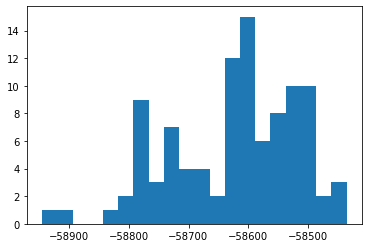

In [307]:
hist, bins = np.histogram(logLs[0], bins=np.linspace(-72500, -72000, 5))
print(hist, bins)
#plt.hist(logLs[0], bins=np.linspace(-72500, -72000, 5), width=50)
plt.hist(logLs[0], bins=20)
plt.show()

In [ ]:
# KDEs
x_grid = np.linspace(min(data), max(data), 1000)
kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
print(len(random_from_kde), random_from_kde) # these are my star ages
bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

plt.subplot(121)
plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
plt.legend()

In [ ]:
hist, bins = np.histogram(logLs[0], bins=np.linspace(-72500, -72000, 5))
print(hist, bins)
#plt.hist(logLs[0], bins=np.linspace(-72500, -72000, 5), width=50)
plt.hist(logLs[0], bins=20)
plt.show()

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10,10))
fig.set_size_inches(10, 10)
plt.subplots_adjust(wspace=0.5, hspace=1.0)
axes = axes.flatten()

for row in range(len(top_df.ms)):
    m = top_df.ms.to_list()[row]
    b = top_df.bs.to_list()[row]
    logL = top_df.logLs.to_list()[row]
    lam = top_df.lams.to_list()[row]
    y = prob_intact(x, m, b)
    #print(m, b, logL, lam)
    
    plt.subplot(5,2,row+1)
    plt.title('logL = %f' %logL)
    plt.ylabel('P(intact)')
    plt.xlabel('Age (Gyr)')
    plt.xlim([0,10])
    plt.ylim([-0.1,1.1])
    plt.plot(x, y)
    
#plt.title('Probability of staying intact as a function of time')
plt.show()

In [ ]:
plt.figure(figsize=(16,16))
index = 0
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        #hist, bins = np.histogram(logLs[index], bins=20)
        plt.hist(logLs[index], bins=20)
        index += 1
plt.show()
#print(hist, bins)
#plt.hist(logLs[0], bins=np.linspace(-72500, -72000, 5), width=50)
#plt.hist(logLs[0], bins=20)
#ax2 = plt.subplot2grid((11,11), (1,10))
#ax3 = plt.subplot2grid((11,11), (2, 2))
#ax4 = plt.subplot2grid((11,11), (3, 3))
#ax5 = plt.subplot2grid((11,11), (10, 0))
#plt.show()

#### Run loglike_direct_draw

In [196]:
# set up "hypercube" prior and iterate through it while calling model and likelihood functions
ndim = 2
nparams = 2
lams = []
logLs = []
ms = []
bs = []
for gi_m in range(11):
    for gi_b in range(11):
        cube = [random.uniform(0,1), random.uniform(0,1)] # instantiate cube
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b) # move to new position on cube
        ms.append(round(cube[0],1))
        bs.append(round(cube[1],1))
        logL, lam = loglike_direct_draw(cube, ndim, nparams) # calculate logL by comparing model(cube) and k
        print(lam)
        lam = lam.to_list()
        lams.append(lam)
        logLs.append(logL)
df = pd.DataFrame({'ms': ms, 'bs': bs, 'logLs': logLs, 'lams': lams})
print(df)
print(lams)
#lams.to_csv('lams_cands.csv', index=False)
df.to_csv('direct/logL_cands.csv', index=False, sep='\t')

<ipython-input-189-15c3f7780ad2>:216: RuntimeWarning: invalid value encountered in sqrt
  arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)


0    19053
1      842
2       74
Name: transit_multiplicity, dtype: int64
0    18954
1      934
2       81
Name: transit_multiplicity, dtype: int64
0    19048
1      854
2       67
Name: transit_multiplicity, dtype: int64
0    19016
1      894
2       59
Name: transit_multiplicity, dtype: int64
0    19004
1      898
2       67
Name: transit_multiplicity, dtype: int64
0    19001
1      875
2       92
3        1
Name: transit_multiplicity, dtype: int64
0    19028
1      875
2       65
3        1
Name: transit_multiplicity, dtype: int64
0    19075
1      816
2       76
4        2
Name: transit_multiplicity, dtype: int64
0    19006
1      877
2       82
3        3
4        1
Name: transit_multiplicity, dtype: int64
0    18966
1      925
2       74
4        3
3        1
Name: transit_multiplicity, dtype: int64
0    18925
1      938
2       90
3       11
4        4
5        1
Name: transit_multiplicity, dtype: int64
0    18991
1      903
2       75
Name: transit_multiplicity, dtype: int64
0 

0    19035
1      867
2       67
Name: transit_multiplicity, dtype: int64
0    18973
1      902
2       89
3        2
4        2
5        1
Name: transit_multiplicity, dtype: int64
0    18977
1      889
2       90
3       10
4        3
Name: transit_multiplicity, dtype: int64
0    18955
1      896
2       91
3       11
4       11
5        5
Name: transit_multiplicity, dtype: int64
0    18883
1      913
2      105
3       43
4       17
5        6
6        2
Name: transit_multiplicity, dtype: int64
0    18799
1      906
2      138
3       68
4       41
5       17
Name: transit_multiplicity, dtype: int64
0    18737
1      890
2      197
3       85
4       39
5       18
6        3
Name: transit_multiplicity, dtype: int64
0    18610
1      900
2      248
3      129
4       57
5       23
6        2
Name: transit_multiplicity, dtype: int64
0    18538
1      910
2      263
3      149
4       79
5       29
6        1
Name: transit_multiplicity, dtype: int64
0    18503
1      838
2      329
3   

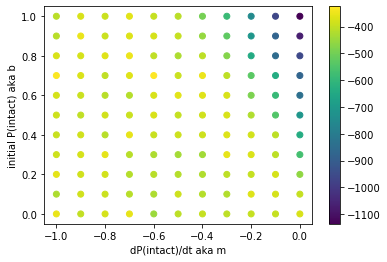

In [197]:
plt.scatter(ms, bs, c=logLs)
plt.ylabel('initial P(intact) aka b')
plt.xlabel('dP(intact)/dt aka m')
plt.colorbar()
plt.show()

In [201]:
from ast import literal_eval

logL_cands = pd.read_csv('direct/logL_cands.csv', sep='\t')
print(logL_cands.head())
print(logL_cands.lams[0])
logL_cands.lams = logL_cands.lams.apply(literal_eval) # convert back from string to list of floats


    ms   bs       logLs              lams
0 -1.0  0.0 -352.152308  [19053, 842, 74]
1 -1.0  0.1 -424.624639  [18954, 934, 81]
2 -1.0  0.2 -358.925549  [19048, 854, 67]
3 -1.0  0.3 -387.285609  [19016, 894, 59]
4 -1.0  0.4 -392.117299  [19004, 898, 67]
[19053, 842, 74]


In [208]:
print(logL_cands.loc[(logL_cands.ms == -1.0) & (logL_cands.bs == 0.7)].lams)
print(logL_cands.loc[(logL_cands.ms == 0) & (logL_cands.bs == 1.0)].lams)
print(np.sum(k), np.sum(np.sum(logL_cands.loc[(logL_cands.ms == 0) & (logL_cands.bs == 1.0)].lams)))


7    [19075, 816, 76, 2]
Name: lams, dtype: object
120    [18125, 797, 493, 305, 168, 67, 14]
Name: lams, dtype: object
19969 19969


In [203]:
k
[19035, 824, 91, 10, 5, 2, 2]

0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64

In [211]:
print(np.abs(19653-19075) + np.abs(244-816) + np.abs(51-76) + np.abs(12-2))
print(np.abs(19653-18125) + np.abs(244-797) + np.abs(51-493) + np.abs(12-305))


1185
2816


Model and transit multiplicity plots for selected high-logL models

     ms   bs       logLs                           lams
51 -0.6  0.7 -324.254451  [19035, 824, 91, 10, 5, 2, 2]
7  -1.0  0.7 -330.220558            [19075, 816, 76, 2]
41 -0.7  0.8 -347.017900      [19010, 863, 81, 7, 7, 1]
73 -0.4  0.7 -348.847639     [18988, 850, 93, 27, 7, 4]
20 -0.9  0.9 -350.543955      [19014, 869, 72, 7, 5, 2]
0  -1.0  0.0 -352.152308               [19053, 842, 74]
33 -0.7  0.0 -353.695403               [19043, 834, 92]
37 -0.7  0.4 -355.009622         [19046, 839, 82, 1, 1]
80 -0.3  0.3 -355.487972            [19050, 846, 72, 1]
25 -0.8  0.3 -358.479868               [19041, 847, 81]


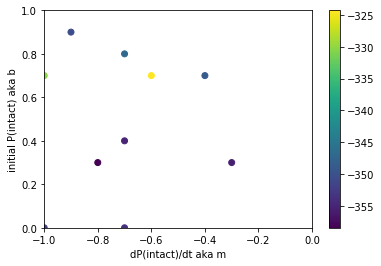

In [212]:
print(df.sort_values(['logLs'], ascending=False).head(n=10))
top_df = df.sort_values(['logLs'], ascending=False).head(n=10)
plt.scatter(top_df.ms.to_list(), top_df.bs.to_list(), c=top_df.logLs.to_list())
plt.ylabel('initial P(intact) aka b')
plt.xlabel('dP(intact)/dt aka m')
plt.ylim(0., 1.)
plt.xlim(-1., 0.)
plt.colorbar()
plt.show()

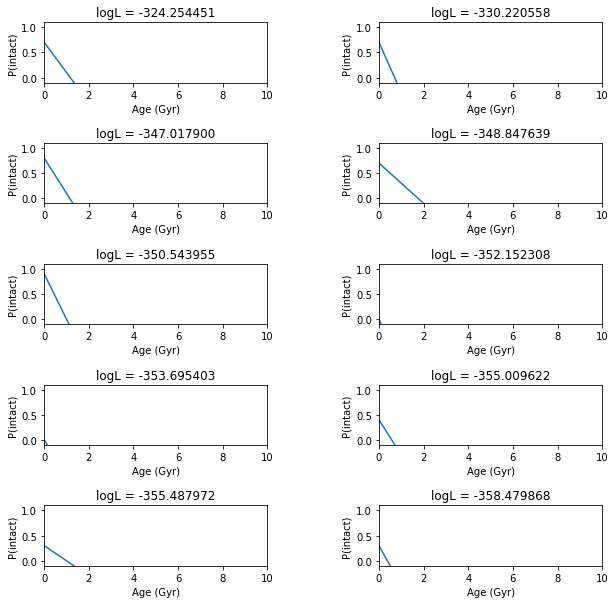

In [213]:
def prob_intact(x, m, b):
    prob = m*x + b
    for i in prob:
        if i < 0: # don't allow negative probabilities
            i = 0
    return prob

# Model and transit multiplicity plots for selected high-logL models
top_ms, top_bs = top_df.ms.to_list(), top_df.bs.to_list()
x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10,10))
fig.set_size_inches(10, 10)
plt.subplots_adjust(wspace=0.5, hspace=1.0)
axes = axes.flatten()

for row in range(len(top_df.ms)):
    m = top_df.ms.to_list()[row]
    b = top_df.bs.to_list()[row]
    logL = top_df.logLs.to_list()[row]
    lam = top_df.lams.to_list()[row]
    y = prob_intact(x, m, b)
    #print(m, b, logL, lam)
    
    plt.subplot(5,2,row+1)
    plt.title('logL = %f' %logL)
    plt.ylabel('P(intact)')
    plt.xlabel('Age (Gyr)')
    plt.xlim([0,10])
    plt.ylim([-0.1,1.1])
    plt.plot(x, y)
    
#plt.title('Probability of staying intact as a function of time')
plt.show()

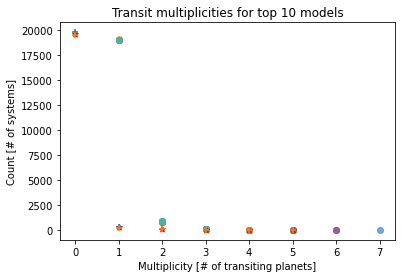

In [217]:
for i in range(len(top_df.ms)):
    logL = top_df.logLs.to_list()[i]
    lam = pd.Series(top_df.lams.to_list()[i])
    print(logL)
    lam.index += 1 # reset indices starting at 1 after reading back from list
    #print(lam)
    
    plt.title('Transit multiplicities for top 10 models')
    plt.ylabel('Count [# of systems]')
    plt.xlabel('Multiplicity [# of transiting planets]')
    
    plt.scatter(pd.Series(lam).index, lam, alpha=0.6)
    
plt.scatter(np.arange(6), k, marker=(5, 1), color='r')
plt.scatter(np.arange(6), k+np.sqrt(k), marker='+')
plt.scatter(np.arange(6), k-np.sqrt(k), marker='+')
plt.show()

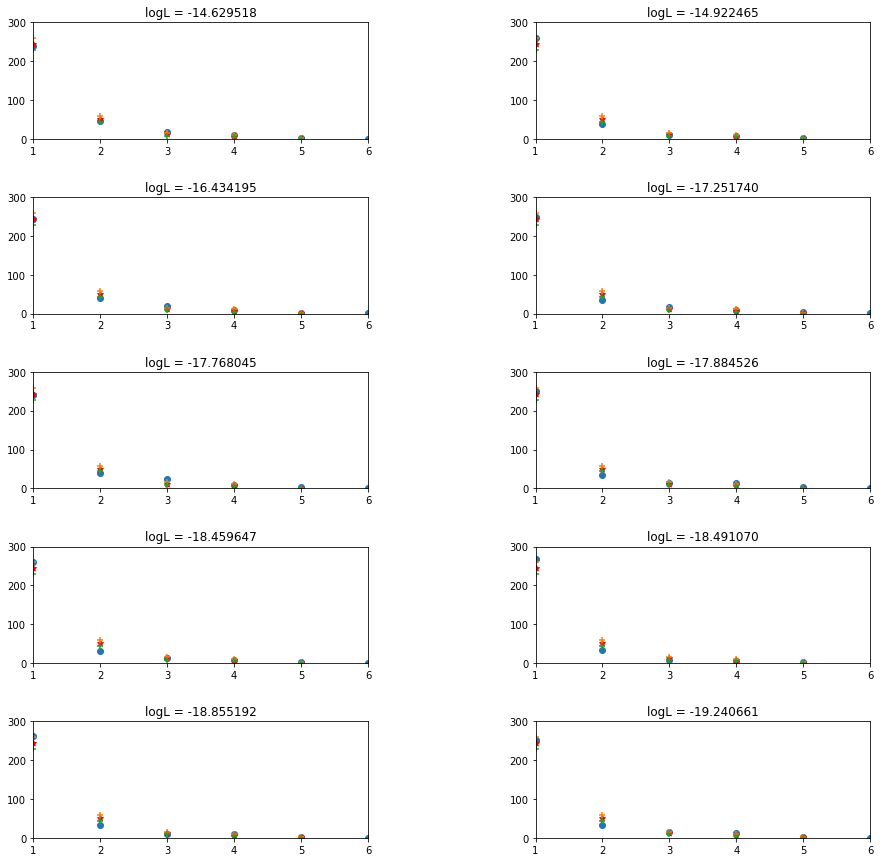

In [97]:
# Model and transit multiplicity plots for selected high-logL models
top_ms, top_bs = top_df.ms.to_list(), top_df.bs.to_list()
x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10,10))
fig.set_size_inches(15, 15)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axes = axes.flatten()

for row in range(len(top_df.ms)):    
    logL = top_df.logLs.to_list()[row]
    lam = pd.Series(top_df.lams.to_list()[row])
    lam.index += 1 # reset indices starting at 1 after reading back from list
    #print(lam)
    
    plt.subplot(5,2,row+1)
    plt.title('logL = %f' %logL)
    #plt.ylabel('Count [# of systems]')
    #plt.xlabel('Multiplicity [# of transiting planets]')
    plt.xlim(1, 6)
    plt.ylim(0, 300)
    plt.scatter(pd.Series(lam).index, lam)
    plt.scatter(np.arange(6)[1:], k, marker=(5, 1), color='r')
    plt.scatter(np.arange(6)[1:], k+np.sqrt(k), marker='+')
    plt.scatter(np.arange(6)[1:], k-np.sqrt(k), marker='+')

#plt.title('Probability of staying intact as a function of time')
plt.show()

In [28]:
# set up "hypercube" prior and iterate through it while calling model and likelihood functions
ndim = 2
nparams = 2
lams = []
logLs = []
ms = []
bs = []
for gi_m in range(11):
    for gi_b in range(11):
        cube = [random.uniform(0,1), random.uniform(0,1)] # instantiate cube
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b) # move to new position on cube
        ms.append(round(cube[0],1))
        bs.append(round(cube[1],1))
        logL, lam = loglike(cube, ndim, nparams) # calculate logL by comparing model(cube) and k
        print(lam)
        lam = lam.to_list()
        lams.append(lam)
        logLs.append(logL)
df = pd.DataFrame({'ms': ms, 'bs': bs, 'logLs': logLs, 'lams': lams})
print(df)
print(lams)
#lams.to_csv('lams_cands.csv', index=False)
df.to_csv('logL_cands.csv', index=False, sep='\t')

1    300.140527
2     15.859473
Name: transit_multiplicity, dtype: float64
1    297.072917
2     18.927083
Name: transit_multiplicity, dtype: float64
1    301.457711
2     14.542289
Name: transit_multiplicity, dtype: float64
1    298.280374
2     17.719626
Name: transit_multiplicity, dtype: float64
1    296.825243
2     18.791262
5      0.383495
Name: transit_multiplicity, dtype: float64
1    295.113831
2     20.112607
4      0.773562
Name: transit_multiplicity, dtype: float64
1    294.804878
2     20.039024
5      0.770732
3      0.385366
Name: transit_multiplicity, dtype: float64
1    299.245376
2     14.806412
3      1.168927
4      0.389642
5      0.389642
Name: transit_multiplicity, dtype: float64
1    292.549878
2     19.605839
4      1.537713
3      1.153285
5      1.153285
Name: transit_multiplicity, dtype: float64
1    285.316520
2     24.706179
3      3.586381
4      1.195460
5      1.195460
Name: transit_multiplicity, dtype: float64
1    290.378378
2     20.963145
3      2.7

1    287.306604
2     22.358491
3      3.726415
4      1.863208
5      0.745283
Name: transit_multiplicity, dtype: float64
1    274.551143
2     29.660650
3      5.703971
4      5.323706
5      0.760529
Name: transit_multiplicity, dtype: float64
1    269.893238
2     27.739027
3      9.746145
4      5.997628
5      2.249110
6      0.374852
Name: transit_multiplicity, dtype: float64
1    242.839130
2     40.873913
3     18.547826
4      9.617391
5      2.747826
6      1.373913
Name: transit_multiplicity, dtype: float64
1    232.948718
2     41.525641
3     22.619658
4     13.841880
5      4.388889
6      0.675214
Name: transit_multiplicity, dtype: float64
1    224.405797
2     48.741201
3     22.898551
4     13.739130
5      5.888199
6      0.327122
Name: transit_multiplicity, dtype: float64
1    198.929524
2     58.384762
3     34.308571
4     17.455238
5      5.417143
6      1.504762
Name: transit_multiplicity, dtype: float64
1    299.263556
2     16.736444
Name: transit_multiplicity,

#### Redo with Sarah's fake k 

In [31]:
# test k given by Sarah
new_k = pd.Series([129, 20, 10, 2, 0, 0]) # compact multi rate with 7%
np.sum(new_k)

161

In [38]:
# set up "hypercube" prior and iterate through it while calling model and likelihood functions
ndim = 2
nparams = 2
lams = []
logLs = []
ms = []
bs = []
k = new_k
for gi_m in range(11):
    for gi_b in range(11):
        cube = [random.uniform(0,1), random.uniform(0,1)] # instantiate cube
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b) # move to new position on cube
        ms.append(round(cube[0],1))
        bs.append(round(cube[1],1))
        logL, lam = loglike(cube, ndim, nparams) # calculate logL by comparing model(cube) and k
        lam = lam.to_list()
        print(lam)
        lams.append(lam)
        logLs.append(logL)
df = pd.DataFrame({'ms': ms, 'bs': bs, 'logLs': logLs, 'lams': lams})
print(df)
df.to_csv('logL_cands_fake_k.csv', index=False, sep='\t')


1    149.875628
2     11.124372
Name: transit_multiplicity, dtype: float64
1    151.428062
2      9.571938
Name: transit_multiplicity, dtype: float64
1    153.526525
2      7.473475
Name: transit_multiplicity, dtype: float64
1    150.911227
2     10.088773
Name: transit_multiplicity, dtype: float64
1    149.938931
2     11.061069
Name: transit_multiplicity, dtype: float64
1    150.988579
2      9.602792
3      0.408629
Name: transit_multiplicity, dtype: float64
1    150.526786
2      9.857143
4      0.410714
3      0.205357
Name: transit_multiplicity, dtype: float64
1    149.747312
2     10.387097
3      0.649194
5      0.216398
Name: transit_multiplicity, dtype: float64
1    150.837871
2      8.966584
3      0.797030
4      0.199257
5      0.199257
Name: transit_multiplicity, dtype: float64
1    149.290909
2      9.200000
3      1.254545
4      0.627273
5      0.627273
Name: transit_multiplicity, dtype: float64
1    146.292326
2      9.609013
3      3.333739
4      0.980512
5      0.5

1    146.160354
2     10.367424
3      3.049242
4      1.016414
5      0.203283
6      0.203283
Name: transit_multiplicity, dtype: float64
1    141.178392
2     13.146985
3      3.842965
4      2.224874
5      0.606784
Name: transit_multiplicity, dtype: float64
1    132.654930
2     17.951878
3      6.613850
4      3.212441
5      0.566901
Name: transit_multiplicity, dtype: float64
1    125.587740
2     18.963942
3      9.868990
4      4.837740
5      1.741587
Name: transit_multiplicity, dtype: float64
1    118.158798
2     21.593348
3     11.574034
4      6.391631
5      2.936695
6      0.345494
Name: transit_multiplicity, dtype: float64
1    108.818182
2     25.454545
3     15.590909
4      8.431818
5      2.068182
6      0.636364
Name: transit_multiplicity, dtype: float64
1    103.119205
2     26.350993
3     17.516556
4      9.291391
5      3.807947
6      0.913907
Name: transit_multiplicity, dtype: float64
1    153.161049
2      7.838951
Name: transit_multiplicity, dtype: float64


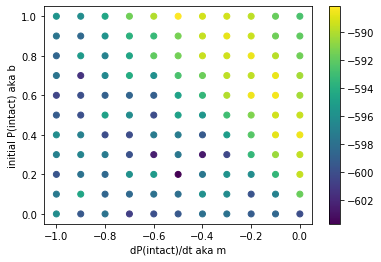

In [39]:
plt.scatter(ms, bs, c=logLs)
plt.ylabel('initial P(intact) aka b')
plt.xlabel('dP(intact)/dt aka m')
plt.colorbar()
plt.show()

#### Comparing young (<1 Gyr) and old (>=1 Gyr) transit mulitplicities. Also comparing flat and non-flat models.

In [175]:
# data
berger_kepler_old = berger_kepler.loc[berger_kepler.iso_age >= 1.]
berger_kepler_young = berger_kepler.loc[berger_kepler.iso_age <= 1.]
print(len(berger_kepler_old), len(berger_kepler_young))
pnum_old = pnum.loc[pnum.iso_age >= 1.]
pnum_young = pnum.loc[pnum.iso_age < 1.]
print(len(old_pnum), len(young_pnum))
k_old = pnum_old.koi_count.value_counts() 
k_young = pnum_young.koi_count.value_counts() 
k_old[0] = len(berger_kepler_old) - np.sum(k_old)
k_old = k_old.sort_values('index', ascending=False)

k_young = pnum_young.koi_count.value_counts() 
k_young[0] = len(berger_kepler_young) - np.sum(k_young)
k_young = k_young.sort_values('index', ascending=False)
print(k_old)
print(k_young)

17505 2514
269 47
0    17236
1      208
2       44
3       10
4        6
5        1
Name: koi_count, dtype: int64
0    2467
1      36
2       7
3       2
4       2
Name: koi_count, dtype: int64


In [131]:
cube = [0., 0.3] # instantiate cube
transits_young, transits_old = model_age_discrim(cube)
print(len(transits_young), len(transits_old))
#transits_old.transit_multiplicity.value_counts() * (np.sum(k_old)/len(transits_old.loc[transits_old.transit_multiplicity > 0]))
print(transits_old.transit_multiplicity.value_counts())
print(transits_young.transit_multiplicity.value_counts())


15 85
0    82
1     1
2     1
3     1
Name: transit_multiplicity, dtype: int64
0    15
Name: transit_multiplicity, dtype: int64


Young vs old transit multiplicities for top 5 models

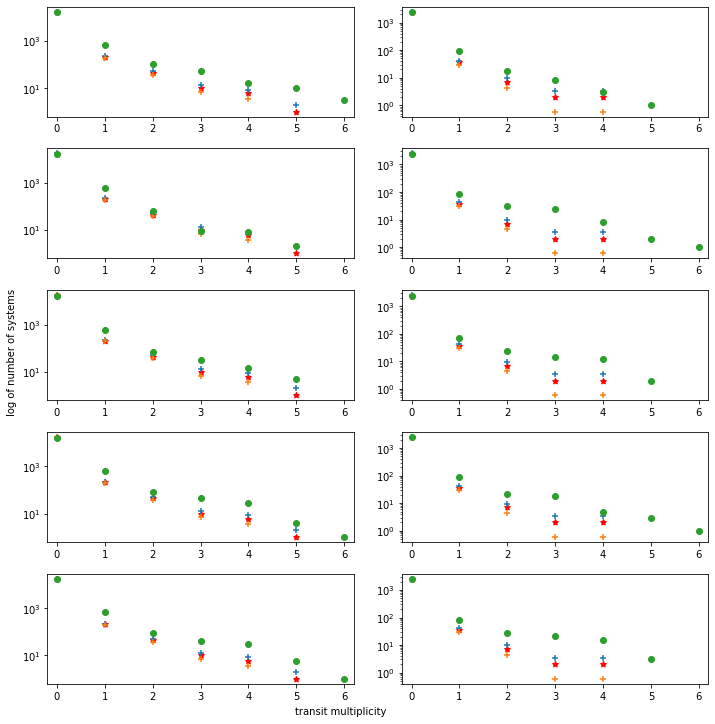

In [185]:
# Re-sampled transit multiplicity plots, now with zero bins, for selected high-logL models
top_ms, top_bs = top_df.ms.to_list(), top_df.bs.to_list()
x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10,10))
fig.set_size_inches(10, 10)
fig.text(0., 0.5, 'log of number of systems', va='center', rotation='vertical')
fig.text(0.4, 0., 'transit multiplicity', va='center', rotation='horizontal')
fig.tight_layout()
#plt.subplots_adjust(wspace=0.5, hspace=0.3)
axes = axes.flatten()

for row in range(int(len(top_df.ms)/2)): # just do the top five, so I can compare old vs young side by side    
    m = top_df.ms.to_list()[row]
    b = top_df.bs.to_list()[row]
    cube = [m, b]
    transits_young, transits_old = model_age_discrim(cube)
    transits_young_multiplicity = transits_young.transit_multiplicity.value_counts()
    transits_old_multiplicity = transits_old.transit_multiplicity.value_counts()

    plt.subplot(5,2,2*row+1)
    plt.scatter(np.arange(6), k_old, marker=(5, 1), color='r')
    plt.scatter(np.arange(6), k_old+np.sqrt(k_old), marker='+')
    plt.scatter(np.arange(6), k_old-np.sqrt(k_old), marker='+')
    plt.scatter(pd.Series(transits_old_multiplicity).index, transits_old_multiplicity)
    plt.xlim(-0.2, 6.2)
    plt.yscale('log')
    #plt.ylim(0, 3e4)
    
    plt.subplot(5,2,2*row+2)
    plt.scatter(np.arange(5), k_young, marker=(5, 1), color='r')
    plt.scatter(np.arange(5), k_young+np.sqrt(k_young), marker='+')
    plt.scatter(np.arange(5), k_young-np.sqrt(k_young), marker='+')
    plt.scatter(pd.Series(transits_young_multiplicity).index, transits_young_multiplicity)
    
    #plt.title('logL = %f' %logL)
    #plt.ylabel('Count [# of systems]')
    #plt.xlabel('Multiplicity [# of transiting planets]')
    plt.xlim(-0.2, 6.2)
    plt.yscale('log')
    #plt.ylim(0, 1e4)

#plt.title('Probability of staying intact as a function of time')
plt.show()

In [186]:
k_young

0    2467
1      36
2       7
3       2
4       2
Name: koi_count, dtype: int64

In [187]:
transits_young_multiplicity # model

0    2445
1      81
2      28
3      21
4      15
5       3
Name: transit_multiplicity, dtype: int64

In [177]:
k_old # data

0    17236
1      208
2       44
3       10
4        6
5        1
Name: koi_count, dtype: int64

In [178]:
transits_old_multiplicity # model

0    16715
1      628
2       87
3       36
4       18
5        5
Name: transit_multiplicity, dtype: int64

Young vs old transit multiplicities for flat to not-flat systems

In [ ]:
# Re-sampled transit multiplicity plots, now with zero bins, for selected high-logL models
top_ms, top_bs = top_df.ms.to_list(), top_df.bs.to_list()
x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10,10))
fig.set_size_inches(10, 10)
fig.text(0., 0.5, 'log of number of systems', va='center', rotation='vertical')
fig.text(0.4, 0., 'transit multiplicity', va='center', rotation='horizontal')
fig.tight_layout()
#plt.subplots_adjust(wspace=0.5, hspace=0.3)
axes = axes.flatten()

for row in range(int(len(top_df.ms)/2)): # just do the top five, so I can compare old vs young side by side    
    m = top_df.ms.to_list()[row]
    b = top_df.bs.to_list()[row]
    cube = [m, b]
    transits_young, transits_old = model_age_discrim(cube)
    transits_young_multiplicity = transits_young.transit_multiplicity.value_counts()
    transits_old_multiplicity = transits_old.transit_multiplicity.value_counts()

    plt.subplot(5,2,2*row+1)
    plt.scatter(np.arange(6), k_old, marker=(5, 1), color='r')
    plt.scatter(np.arange(6), k_old+np.sqrt(k_old), marker='+')
    plt.scatter(np.arange(6), k_old-np.sqrt(k_old), marker='+')
    plt.scatter(pd.Series(transits_old_multiplicity).index, transits_old_multiplicity)
    plt.xlim(-0.2, 6.2)
    plt.yscale('log')
    #plt.ylim(0, 1e4)
    
    plt.subplot(5,2,2*row+2)
    plt.scatter(np.arange(5), k_young, marker=(5, 1), color='r')
    plt.scatter(np.arange(5), k_young+np.sqrt(k_young), marker='+')
    plt.scatter(np.arange(5), k_young-np.sqrt(k_young), marker='+')
    plt.scatter(pd.Series(transits_young_multiplicity).index, transits_young_multiplicity)
    
    #plt.title('logL = %f' %logL)
    #plt.ylabel('Count [# of systems]')
    #plt.xlabel('Multiplicity [# of transiting planets]')
    plt.xlim(-0.2, 6.2)
    plt.yscale('log')
    #plt.ylim(0, 1e4)

#plt.title('Probability of staying intact as a function of time')
plt.show()

In [115]:
# set up "hypercube" prior and iterate through it while calling model and likelihood functions
ndim = 2
nparams = 2
lams_young = []
lams_old = []
logLs_young = []
logLs_old = []
ms = []
bs = []
for gi_m in range(11):
    for gi_b in range(11):
        cube = [random.uniform(0,1), random.uniform(0,1)] # instantiate cube
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b) # move to new position on cube
        ms.append(round(cube[0],1))
        bs.append(round(cube[1],1))
        # retrieve prior cube and feed prior-normalized hypercube into model to generate transit multiplicities
        ###lam_young, lam_old = model_age_discrim(cube)
        transits_young, transits_old = model_age_discrim(cube)
        
        """
        logL_young = loglike_age_discrim(cube, ndim, nparams, lam_young) # calculate logL by comparing model(cube) and k
        logL_old = loglike_age_discrim(cube, ndim, nparams, lam_old) # calculate logL by comparing model(cube) and k
        lams_young.append(lam_young)
        lams_old.append(lam_old)
        logLs_young.append(logL_young)
        logLs_old.append(logL_old)
        """
    
        
df_young = pd.DataFrame({'ms': ms, 'bs': bs, 'logLs': logLs_young, 'lams': lams_young})
df_old = pd.DataFrame({'ms': ms, 'bs': bs, 'logLs': logLs_old, 'lams': lams_old})
print(df_young.head())
print(df_old.head())
df_young.to_csv('logL_cands_young.csv', index=False, sep='\t')
df_old.to_csv('logL_cands_old.csv', index=False, sep='\t')


    ms   bs                                              logLs  \
0 -1.0  0.0  (-370.9175560741892, [45.19230769230769, 1.807...   
1 -1.0  0.1  (-337.5322664723876, [42.13793103448276, 4.862...   
2 -1.0  0.2  (-394.30042053639863, [45.9438202247191, 1.056...   
3 -1.0  0.3  (-392.50961312388586, [45.101010101010104, 1.4...   
4 -1.0  0.4  (-364.89037651490173, [44.901785714285715, 2.0...   

                                                lams  
0  1    45.192308
2     1.807692
Name: transit_mu...  
1  1    42.137931
2     4.862069
Name: transit_mu...  
2  1    45.94382
2     1.05618
Name: transit_mult...  
3  1    45.101010
2     1.424242
3     0.474747
N...  
4  1    44.901786
2     2.098214
Name: transit_mu...  
    ms   bs                                              logLs  \
0 -1.0  0.0  (-65.95353536101652, [254.86336336336336, 14.1...   
1 -1.0  0.1  (-58.517052612363386, [251.60601503759398, 17....   
2 -1.0  0.2  (-59.79118416246342, [252.2373887240356, 16.76...   
3 -1.0  0

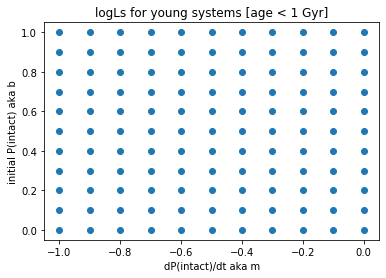

In [122]:
plt.scatter(df_young.ms, df_young.bs) # , c=df_young.logLs
plt.ylabel('initial P(intact) aka b')
plt.xlabel('dP(intact)/dt aka m')
plt.title('logLs for young systems [age < 1 Gyr]')
#plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_old.ms, df_old.bs, c=df_old.logLs)
plt.ylabel('initial P(intact) aka b')
plt.xlabel('dP(intact)/dt aka m')
plt.title('logLs for old systems [age >= 1 Gyr]')
plt.colorbar()
plt.show()

#### Sanity check: do flat line models have no difference in young vs old system transit multiplicities?

#### Let's add S/N

In [41]:
# set up "hypercube" prior and iterate through it while calling model and likelihood functions
ndim = 2
nparams = 2
lams = []
logLs = []
ms = []
bs = []
for gi_m in range(11):
    for gi_b in range(11):
        cube = [random.uniform(0,1), random.uniform(0,1)] # instantiate cube
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b) # move to new position on cube
        ms.append(round(cube[0],1))
        bs.append(round(cube[1],1))
        logL, lam = loglike(cube, ndim, nparams) # calculate logL by comparing model(cube) and k
        print(lam)
        lam = lam.to_list()
        lams.append(lam)
        logLs.append(logL)
df = pd.DataFrame({'ms': ms, 'bs': bs, 'logLs': logLs, 'lams': lams})
print(df)
print(lams)
#lams.to_csv('lams_cands.csv', index=False)
df.to_csv('logL_sn.csv', index=False, sep='\t')

/Users/chris/anaconda2/envs/sculpting/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


TypeError: can't get common type for non-numeric array

#### Below is pymultinest-land. Don't go there. Yet.

In [ ]:
# number of dimensions our problem has
parameters = ["m", "b"]
n_params = len(parameters)

# run MultiNest
#pymultinest.run(sculpting_logL, sculpting_prior, n_params, outputfiles_basename=datafile + '_1_', resume = False, verbose = True)
#pymultinest.run(loglike, prior, n_params, outputfiles_basename=datafile + '_1_', resume = False, verbose = True)
pymultinest.run(loglike, prior, n_params, resume = False, verbose = True)
